In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, median_absolute_error
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation, LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
# from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from optuna.integration import CatBoostPruningCallback
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold
# from imblearn.over_sampling import SMOTE
import optuna
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy.stats import ks_2samp

In [62]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
og = pd.read_csv('ObesityDataSet.csv')
train.shape, test.shape, og.shape

((20758, 18), (13840, 17), (2111, 17))

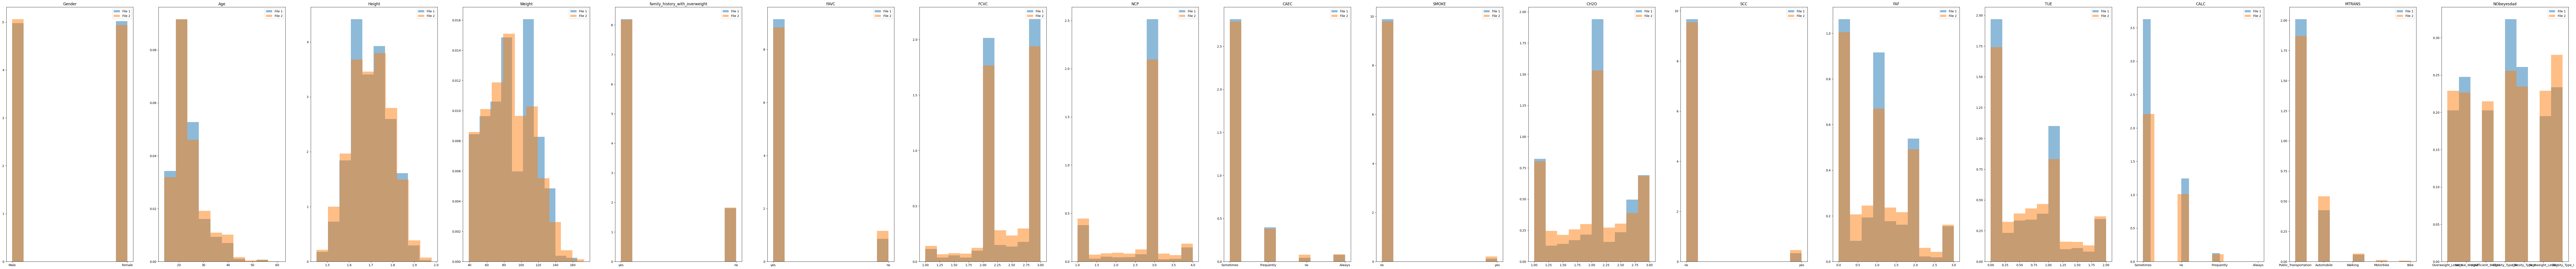

KS Statistic for Gender: 0.00799285479201367, p-value: 0.9996329186071476
KS Statistic for Age: 0.04225518413474649, p-value: 0.0020725023977333874
KS Statistic for Height: 0.033109138086237944, p-value: 0.029300014299136645
KS Statistic for Weight: 0.05512171139214572, p-value: 1.6813706670913613e-05
KS Statistic for family_history_with_overweight: 0.0020138229596629587, p-value: 1.0
KS Statistic for FAVC: 0.0305013644639823, p-value: 0.05543336923679276
KS Statistic for FCVC: 0.06388980335935956, p-value: 3.0475194683618345e-07
KS Statistic for NCP: 0.09466786708887132, p-value: 2.141511080288689e-15
KS Statistic for CAEC: 0.010718565057919238, p-value: 0.9786903323432629
KS Statistic for SMOKE: 0.0090405237884007, p-value: 0.9972482531087944
KS Statistic for CH2O: 0.0686854523370054, p-value: 2.6455524188797115e-08
KS Statistic for SCC: 0.012380403731270806, p-value: 0.9271063215573655
KS Statistic for FAF: 0.0504190333677178, p-value: 0.00011322697462353959
KS Statistic for TUE: 0.

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=len(train.drop('id',axis=1).columns), figsize=(150, 15))

for i, col in enumerate(train.drop('id',axis=1).columns):
    axes[i].hist(train[col], alpha=0.5, label='File 1', density=True)
    axes[i].hist(og[col], alpha=0.5, label='File 2', density=True)
    axes[i].set_title(col)
    axes[i].legend()

plt.show()

# Perform KS test for each column
for col in train.drop('id',axis=1).columns:
    ks_statistic, p_value = ks_2samp(train[col], og[col])
    print(f"KS Statistic for {col}: {ks_statistic}, p-value: {p_value}")

# You can interpret the p-value to determine if the distributions are significantly different
# Typically, if p-value is less than a significance level (e.g., 0.05), you reject the null hypothesis that distributions are the same

In [64]:
train.drop('id',axis=1, inplace=True)
test.drop('id',axis=1, inplace=True)

train = pd.concat([train, og],ignore_index=True)
train.shape, test.shape

((22869, 17), (13840, 16))

In [65]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [66]:
train['BMI'] = train['Weight']/train['Height']**2
train['Drinks_and_Smokes'] = np.where((train['CALC'] == 'no') & (train['SMOKE'] == 'no'), 'no', 'yes')

test['BMI'] = test['Weight']/test['Height']**2
test['Drinks_and_Smokes'] = np.where((test['CALC'] == 'no') & (test['SMOKE'] == 'no'), 'no', 'yes')

train['Drinks Less Water'] = train.apply(lambda row: 'Yes' if (row['Weight'] * 35 / 1000) > row['CH2O'] else 'No', axis=1)
test['Drinks Less Water'] = test.apply(lambda row: 'Yes' if (row['Weight'] * 35 / 1000) > row['CH2O'] else 'No', axis=1)

In [67]:
train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000,22869.000000
mean,23.885263,1.700377,87.767610,2.443428,2.754344,2.027442,0.984382,0.620551,30.191840
std,5.753419,0.087881,26.364243,0.533329,0.712711,0.608901,0.839466,0.602850,8.305989
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541
25%,20.000000,1.631662,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000,24.092971
50%,22.815416,1.700000,84.000000,2.392665,3.000000,2.000000,1.000000,0.579541,29.384757
75%,26.000000,1.763029,111.531208,3.000000,3.000000,2.535127,1.596576,1.000000,36.878525
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991


In [68]:
train.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
Drinks_and_Smokes                 0
Drinks Less Water                 0
dtype: int64

In [69]:
numerical = [col for col in train.columns if train[col].dtype !='O']
categorical = [col for col in train.columns if train[col].dtype =='O']
numerical, categorical

(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI'],
 ['Gender',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SMOKE',
  'SCC',
  'CALC',
  'MTRANS',
  'NObeyesdad',
  'Drinks_and_Smokes',
  'Drinks Less Water'])

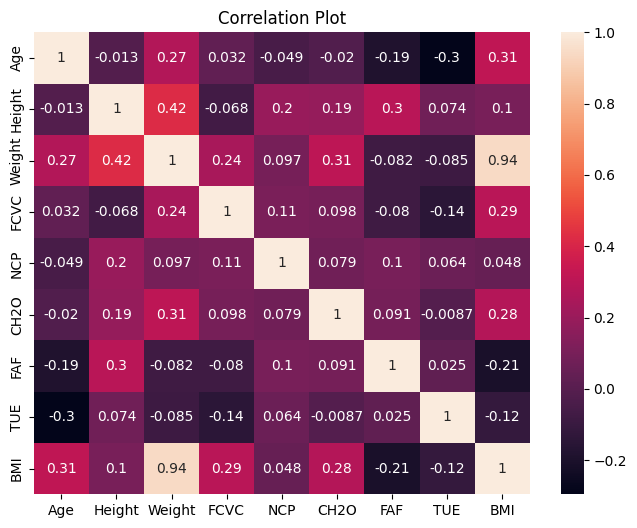

In [70]:
correlation_matrix = train[numerical].corr()
plt.figure(figsize=(8, 6))
color_palette = sns.color_palette('viridis', as_cmap=True)
# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True)

# Show the plot
plt.title('Correlation Plot')
plt.show()

In [57]:
train['NObeyesdad'].value_counts()

Drinks Less Water
Yes    19465
No      3404
Name: count, dtype: int64

In [72]:
train_data = TabularDataset(train)
test_data = TabularDataset(test)
# predictor = TabularPredictor(problem_type='multiclass',label='NObeyesdad',eval_metric='accuracy').fit(train_data=train_data,presets='best_quality',ag_args_fit={'num_gpus': 1},time_limit=7200,hyperparameters={'GBM':{},'CAT':{},'XT':{},'XGB':{}},)
predictor = TabularPredictor(problem_type='multiclass',label='NObeyesdad',eval_metric='accuracy').fit(train_data=train_data,presets='best_quality',ag_args_fit={'num_gpus': 1},time_limit=7200)
predictions = predictor.predict(test_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240202_104215"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels\ag-20240202_104215/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "AutogluonModels\ag-20240202_104215/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1

In [73]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.916962,accuracy,2.647312,93.676540,0.002983,8.686703,2,True,34
1,XGBoost_r89_BAG_L1,0.916874,accuracy,1.912094,83.915662,1.912094,83.915662,1,True,29
2,XGBoost_r33_BAG_L1,0.915475,accuracy,6.867126,205.893971,6.867126,205.893971,1,True,21
3,XGBoost_BAG_L1,0.914775,accuracy,1.209522,75.165740,1.209522,75.165740,1,True,11
4,LightGBM_r131_BAG_L1,0.914557,accuracy,4.195015,369.085418,4.195015,369.085418,1,True,16
5,LightGBM_BAG_L1,0.914469,accuracy,2.328638,171.409077,2.328638,171.409077,1,True,5
6,LightGBMLarge_BAG_L1,0.911234,accuracy,1.521356,354.576435,1.521356,354.576435,1,True,13
7,LightGBM_r96_BAG_L1,0.910796,accuracy,16.318807,451.059433,16.318807,451.059433,1,True,19
8,LightGBMXT_BAG_L1,0.910621,accuracy,2.564574,169.562147,2.564574,169.562147,1,True,4
9,CatBoost_r9_BAG_L1,0.909310,accuracy,0.069015,65.424721,0.069015,65.424721,1,True,18


In [ ]:
predictor = TabularPredictor.load("AutogluonModels\ag-20240113_193141")

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.897380,roc_auc,10.311767,415.921245,0.021000,18.171903,3,True,10
1,WeightedEnsemble_L2,0.897203,roc_auc,3.660372,252.375022,0.022105,9.542348,2,True,5
2,CatBoost_BAG_L2,0.897146,roc_auc,5.765468,320.027333,0.099517,74.507469,2,True,7
3,XGBoost_BAG_L2,0.896821,roc_auc,6.675183,278.453430,1.009232,32.933566,2,True,9
4,CatBoost_BAG_L1,0.896710,roc_auc,0.172601,153.976061,0.172601,153.976061,1,True,2
5,ExtraTrees_BAG_L2,0.894454,roc_auc,8.637967,249.394785,2.972016,3.874921,2,True,8
6,LightGBM_BAG_L2,0.893863,roc_auc,6.210001,286.433386,0.544050,40.913522,2,True,6
7,XGBoost_BAG_L1,0.892757,roc_auc,2.139657,39.180572,2.139657,39.180572,1,True,4
8,LightGBM_BAG_L1,0.891879,roc_auc,1.326010,49.676040,1.326010,49.676040,1,True,1
9,ExtraTrees_BAG_L1,0.882648,roc_auc,2.027683,2.687191,2.027683,2.687191,1,True,3


Autogluon

In [74]:
y_proba = predictor.predict(test_data)

In [80]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 19 features using 5000 rows with 5 shuffle sets...


	186.27s	= Expected runtime (37.25s per shuffle set)
	67.52s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Weight,0.26392,0.004571,1.079142e-08,5,0.273331,0.254509
BMI,0.18896,0.004991,5.834123e-08,5,0.199236,0.178684
FCVC,0.12156,0.002347,1.666443e-08,5,0.126392,0.116728
Gender,0.09140,0.001939,2.429470e-08,5,0.095393,0.087407
TUE,0.05212,0.003474,2.355880e-06,5,0.059274,0.044966
FAF,0.04348,0.003939,7.991389e-06,5,0.051589,0.035371
Age,0.03524,0.002868,5.221549e-06,5,0.041146,0.029334
CH2O,0.01740,0.001655,9.710977e-06,5,0.020808,0.013992
Height,0.01604,0.001615,1.216555e-05,5,0.019365,0.012715
NCP,0.01108,0.001689,6.280402e-05,5,0.014557,0.007603


In [77]:
sample = pd.read_csv('sample_submission.csv')
sample.head()
submission = pd.DataFrame({'id':sample.id,'NObeyesdad':y_proba})
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [78]:
submission.to_csv('Autogluon-FE.csv',index=False)